In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [6]:
'''
Define variables for the number of layers and qubits of the prover. Define global variables used in the optimization.
'''
numLayer = 2
numQubit = 1
global iterations
global noisy

In [10]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

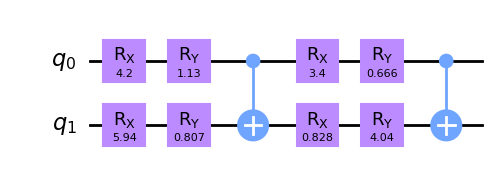

In [9]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([])
size = 2
layers = 2

for i in range(0, 2*size*layers):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [11]:
def createEqSuperposCS4BSE():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(2)
    temp.h(0)
    temp.h(1)
    return temp

In [53]:
def createQuantumCircuit(state, numQubit, numLayer):
    '''
    Creates quantum circuit for the problem. 
    Refer to Appendix E from https://arxiv.org/pdf/2105.12758
    The ciruit contains 4 qubits each labelled as (C, S, S')
    '''
    circ = QuantumCircuit(4)
    
    superPosCircuit = createEqSuperposCS4BSE()
    circ.append(superPosCircuit, [0, 1])

    circ.append(state, [2, 3])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [3])
    
    circ.cswap(1, 2, 3)
    circ.cx(1, 2)
    
    circ.cx(0, 3)
    circ.cx(0, 2)
    
    circ.append(superPosCircuit.inverse(), [0, 1])
    
    return circ

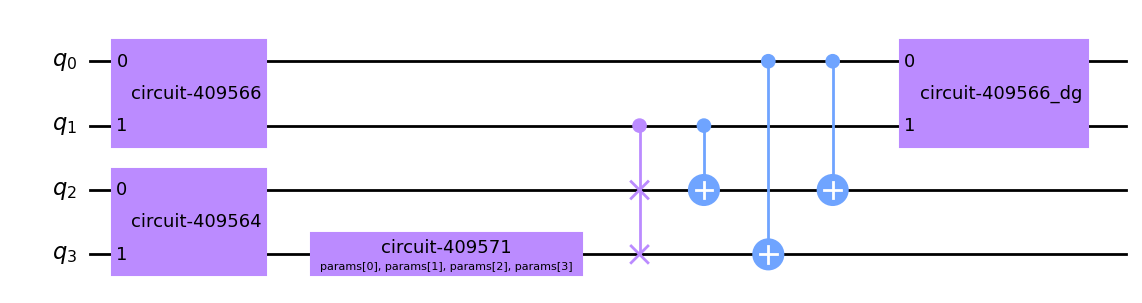

In [54]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [60]:
'''
List of parameters of the quantum circuit.
'''
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3])])


In [55]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [56]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation.
'''
provider = IBMQ.get_provider(hub='ibm-q')
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_lima")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [58]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [59]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [61]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [57]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the first two qubits.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [62]:
'''
Initialize prover parameters to random angles
'''
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[3.72429969 3.31560456 3.5586304  0.00663216]
Initial Cost :  0.5309288251859604


In [63]:
'''
True value calculated using the SDP.
'''
true_value = 0.9330

In [64]:
'''
Perform the noiseless optimization using the SPSA algorithm for 200 iterations.
'''
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.5309288251859604
Loss Value :  0.5443852940156284 1.0%
Loss Value :  0.24009901578570939 2.0%
Loss Value :  0.31332037139013047 3.0%
Loss Value :  0.4007891971820293 4.0%
Loss Value :  0.46802074256171977 5.0%
Loss Value :  0.4808911175227167 6.0%
Loss Value :  0.6997372868214352 7.0%
Loss Value :  0.9025330750289222 8.0%
Loss Value :  0.9060875396960335 9.0%
Loss Value :  0.921639609122672 10.0%
Loss Value :  0.9222976228971251 11.0%
Loss Value :  0.9223132828104091 12.0%
Loss Value :  0.928486062851773 13.0%
Loss Value :  0.9310524836885121 14.0%
Loss Value :  0.9310693496668564 15.0%
Loss Value :  0.9312388614310669 16.0%
Loss Value :  0.9312399886169276 17.0%
Loss Value :  0.931764920684321 18.0%
Loss Value :  0.9323027342719516 19.0%
Loss Value :  0.932837482902811 20.0%
Loss Value :  0.9328624787991817 21.0%
Loss Value :  0.9329706587852383 22.0%
Loss Value :  0.9329709201245426 23.0%
Loss Value :  0.9329814948152837 24.0%
Loss Value :  0.9329691212400899 25.0%


In [65]:
'''
Perform the noisy optimization using the SPSA algorithm for 200 iterations.
'''
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.5003163912845092
Loss Value :  0.5108491662171684 1.0%
Loss Value :  0.5067661407102174 2.0%
Loss Value :  0.5137202960178195 3.0%
Loss Value :  0.778356701967454 4.0%
Loss Value :  0.7715511536827447 5.0%
Loss Value :  0.7748758428403653 6.0%
Loss Value :  0.7740457951029425 7.0%
Loss Value :  0.8487026419958094 8.0%
Loss Value :  0.8631800914016973 9.0%
Loss Value :  0.8604478269076122 10.0%
Loss Value :  0.8640602944077161 11.0%
Loss Value :  0.8632881861575338 12.0%
Loss Value :  0.8602864275400295 13.0%
Loss Value :  0.8734664409376518 14.0%
Loss Value :  0.8670268179837858 15.0%
Loss Value :  0.8717748537224782 16.0%
Loss Value :  0.8759590993457611 17.0%
Loss Value :  0.8580553087758745 18.0%
Loss Value :  0.8556712178207376 19.0%
Loss Value :  0.8664585579673484 20.0%
Loss Value :  0.8523930071397722 21.0%
Loss Value :  0.8629459588500382 22.0%
Loss Value :  0.8751140379277239 23.0%
Loss Value :  0.875993395458887 24.0%
Loss Value :  0.8679758693217882 25.0%
L

In [66]:
'''
Evaluate the noiseless cost function using the parameters learned from the noisy optimization. 
'''
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.9329626711796913


In [67]:
'''
Print all final values after training.
'''
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.933
Noiseless :  0.9330104445449265
Noisy :  0.8689686274097765
Noise Resilient Value :  0.9329626711796913


In [34]:
def writeToFile():
    '''
    Write the training data to a text file to be used to plot the data. The format is as follows:
        True Value
        Noise Resilient Value
        Size of noiseless data list
        [
        Noiseless data with one entry per line
        ]
        Size of noisy data list
        [
        Noisy data with one entry per line
        ]
    '''
    file = open("CS4_GBSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [35]:
writeToFile()